# Evolution model

In [3]:
import random                  
import math
import numpy as np
import copy
from matplotlib import pyplot as plt

Lets first define an "animal" class.

In [4]:
class Animal:
    def __init__(self, position = 0, health = 50, speed = 0, agitation = 20):
        """Position : float between -1 and 1 excluded (default : 0). Health : integer between 0 and 100 (default : 50).
           Speed : float (default : 0). Agitation : integer between 0 and 100 (default : 20)."""
        self.position_ = position
        self.health_ = health
        self.agitation_ = agitation
        self.speed_ = speed
    
    # Getters
    def getPosition(self):
        return self.position_
    
    def getHealth(self):
        return self.health_
    
    def getAgitation(self):
        return self.agitation_
    
    def getSpeed(self):
        return self.speed_
    
    # Setters
    def setPosition(self, position):
        self.position_ = position
    
    def setHealth(self, health):
        self.health_ = health
    
    def setAgitation(self, agitation):
        self.agitation_ = agitation
    
    def setSpeed(self, speed):
        self.speed_ = speed

In the following, we will consider 3 "animals" : 
 - 1 carnivor (example : Lion)
 - 1 herbivor (example : gazelle)
 - 1 plant

The lion will be denoted (1), gazelle (2) and plant (3). Their position is also associated to an $x$-coordinate.

We know that the lion want to eat the gazelle, who wants to eat the plant, who (lets suppose to) wants to eat the lion. Then lion is attracted to gazelle but fears the plant etc... One way to model it is with the following system of differential equations :
$$\ddot{x}_1 = A_1(x_2 - x_1) + B_1sgn(x_1-x_3)e^{\left( \frac{x_1-x_3}{C_1} \right)^2} - D_1sgn(x_1)\left(\frac{1}{1-|x_1|} - 1\right) - E_1\dot{x_1}^2$$
$$\ddot{x}_2 = A_2(x_3 - x_2) + B_2sgn(x_2-x_1)e^{\left( \frac{x_2-x_1}{C_2} \right)^2} - D_2sgn(x_2)\left(\frac{1}{1-|x_2|} - 1\right) - E_2\dot{x_2}^2$$
$$\ddot{x}_3 = A_3(x_1 - x_3) + B_3sgn(x_3-x_2)e^{\left( \frac{x_3-x_2}{C_3} \right)^2} - D_3sgn(x_3)\left(\frac{1}{1-|x_3|} - 1\right) - E_3\dot{x_3}^2$$
$A$ corresponds to hunger, $B$ to fear, $C$ to fear distance (from which distance do you run away from your predator), $D$ corresponds to border repulsion, and $E$ to air friction.

Lets code an engine that will do the simulation.

In [5]:
class Engine:
    def __init__(self, animals, pos_param, inter, tfin = 60, N = 1000, BC = True):
        """Animals : vector of 3 Animal. pos_param : Ex3 matrix with lign A, B, C, D, E. inter : damage/gain interaction.
        tfin : in seconds (default 60). N : number un time steps (default 1 000)."""
        # Conceptual data
        self.animals_ = animals
        self.panic() # initialize true values of aggitation
        # Position
        self.A_ = pos_param[0]
        self.B_ = pos_param[1]
        self.C_ = pos_param[2]
        self.D_ = pos_param[3]
        self.E_ = pos_param[4]
        # Health interactions
        self.interaction_ = inter
        
        # Numerical data
        self.tfin_ = tfin
        self.N_ = N
        self.dt_ = tfin/N
        self.BC_ = BC
    
    def step(self):
        """Numerical integration of differential system of equation for position (verlet algorithm).
        Changing values of agitation and health."""
        # ================== Physical movement =====================
        pos = [animal.getPosition() for animal in self.animals_]
        vel = [animal.getSpeed() for animal in self.animals_]
        acc = self.acceleration(pos, vel)
        
        next_pos = []
        for i in range(len(pos)):
            next_pos.append(pos[i] + vel[i]*self.dt_ + acc[i]*self.dt_*self.dt_/2)
        
        semi_vel = []
        for i in range(len(vel)):
            semi_vel.append(vel[i] + acc[i]*self.dt_/2)
        
        semi_acc = self.acceleration(pos, semi_vel)
        next_acc = self.acceleration(next_pos, semi_vel)
        next_vel = []
        for i in range(len(vel)):
            next_vel.append(vel[i] + (next_acc[i] + semi_acc[i])*self.dt_/2)
        
       # Imposing boundary conditions : zero speed when hit a border
        if (self.BC_):
            for i in range(len(next_pos)):
                if (next_pos[i] >= 1):
                    next_pos[i] = 1 - random.uniform(1e-5,1e-2)
                    next_vel[i] = -0
                elif (next_pos[i] <= -1):
                    next_pos[i] = -1 + random.uniform(1e-3,1e-2)
                    next_vel[i] = -0
    
        
        # ================= Agitation ==================
        self.panic()
        new_agg = []
        for animal in self.animals_:
            new_agg.append(animal.getAgitation())
        # ================== Health ====================
        self.hunt(next_pos)
        new_health = []
        for animal in self.animals_:
            new_health.append(animal.getHealth())
        
        # Position incrementation
        for i in range(len(self.animals_)):
            self.animals_[i].setPosition(next_pos[i])
            self.animals_[i].setSpeed(next_vel[i])
        
        return [next_pos, next_vel, new_agg, new_health]

    
    def acceleration(self, pos, vel):
        """Used in step. Define the velocities according to differential system of equation."""
        result = []
        a = self.A_[0]*(pos[1] - pos[0]) + self.B_[0]*np.sign(pos[0] - pos[2])*math.exp(-((pos[0] - pos[2])/self.C_[0])**2)- self.D_[0]*np.sign(pos[0])*(1/(1 - abs(pos[0]))-1) - self.E_[0]*vel[0]**2
        result.append(a)
        a = self.A_[1]*(pos[2] - pos[1]) + self.B_[1]*np.sign(pos[1] - pos[0])*math.exp(-((pos[1] - pos[0])/self.C_[1])**2) - self.D_[1]*np.sign(pos[1])*(1/(1 - abs(pos[1]))-1) - self.E_[1]*vel[1]**2
        result.append(a)
        a = self.A_[2]*(pos[0] - pos[2]) + self.B_[2]*np.sign(pos[2] - pos[1])*math.exp(-((pos[2] - pos[1])/self.C_[2])**2)- self.D_[2]*np.sign(pos[2])*(1/(1 - abs(pos[2]))-1) - self.E_[2]*vel[2]**2
        result.append(a)
        return result
    
    def hunt(self, new_pos):
        """Modify the value of health when acounter occurs. To use BEFORE incrementation of new positions."""
        # Interaction lion - gazelle
        if (np.sign(self.animals_[0].getPosition() - self.animals_[1].getPosition()) != np.sign(new_pos[0] - new_pos[1])):
            self.animals_[0].setHealth(self.animals_[0].getHealth() + self.interaction_[0])
            self.animals_[1].setHealth(self.animals_[1].getHealth() - self.interaction_[0])
        # Interaction gazelle - grass
        if (np.sign(self.animals_[1].getPosition() - self.animals_[2].getPosition()) != np.sign(new_pos[1] - new_pos[2])):
            self.animals_[1].setHealth(self.animals_[1].getHealth() + self.interaction_[1])
            self.animals_[2].setHealth(self.animals_[2].getHealth() - self.interaction_[1])
        # Interaction grass - lion
        if (np.sign(self.animals_[2].getPosition() - self.animals_[0].getPosition()) != np.sign(new_pos[2] - new_pos[0])):
            self.animals_[2].setHealth(self.animals_[2].getHealth() + self.interaction_[2])
            self.animals_[0].setHealth(self.animals_[0].getHealth() - self.interaction_[2])
    
    def panic(self):
        """Modify the value of agitation = proportionnal to the distance to the prey."""
        self.animals_[0].setAgitation(100 - round(abs(self.animals_[0].getPosition() - self.animals_[2].getPosition())*50))
        self.animals_[1].setAgitation(100 - round(abs(self.animals_[1].getPosition() - self.animals_[0].getPosition())*50))
        self.animals_[2].setAgitation(100 - round(abs(self.animals_[2].getPosition() - self.animals_[1].getPosition())*50))

    
    def run(self):
        """Run simulations. Output : t (vector of time values), carnivore, herbivore, plant.
        Animal vector are such that : lign 0 = position, lign 1 = velocity."""
        t = 0
        t_all = [0]
        carnivore = [[self.animals_[0].getPosition()], [self.animals_[0].getSpeed()], [self.animals_[0].getAgitation()], [self.animals_[0].getHealth()]]
        herbivore = [[self.animals_[1].getPosition()], [self.animals_[1].getSpeed()], [self.animals_[1].getAgitation()], [self.animals_[1].getHealth()]]
        plant = [[self.animals_[2].getPosition()], [self.animals_[2].getSpeed()], [self.animals_[2].getAgitation()], [self.animals_[2].getHealth()]]
        while (t<self.tfin_):
            [new_pos, new_vel, new_agg, new_health] = self.step()
            t += self.dt_
            t_all.append(t)
            # Add new position to vector
            carnivore[0].append(new_pos[0])
            herbivore[0].append(new_pos[1])
            plant[0].append(new_pos[2])
            # Add new velocities
            carnivore[1].append(new_vel[0])
            herbivore[1].append(new_vel[1])
            plant[1].append(new_vel[2])
            # Add new agitations
            carnivore[2].append(new_agg[0])
            herbivore[2].append(new_agg[1])
            plant[2].append(new_agg[2])
            # Add new health
            carnivore[3].append(new_health[0])
            herbivore[3].append(new_health[1])
            plant[3].append(new_health[2])
        
        return [t_all, carnivore, herbivore, plant]

Function to plot everything

In [6]:
def showall(t, carnivore, herbivore, plant):
    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[0], label='Lion')
    plt.plot(t, herbivore[0], label='Gazelle')
    plt.plot(t, plant[0], label='Grass')
    plt.title('Position')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[1], label='Lion')
    plt.plot(t, herbivore[1], label='Gazelle')
    plt.plot(t, plant[1], label='Grass')
    plt.title('Velocity')
    plt.xlabel('t')
    plt.ylabel('v')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[2], label='Lion')
    plt.plot(t, herbivore[2], label='Gazelle')
    plt.plot(t, plant[2], label='Grass')
    plt.title('Agitation')
    plt.xlabel('t')
    plt.ylabel('a')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 3))
    plt.plot(t, carnivore[3], label='Lion')
    plt.plot(t, herbivore[3], label='Gazelle')
    plt.plot(t, plant[3], label='Grass')
    plt.title('Health')
    plt.xlabel('t')
    plt.ylabel('H')
    plt.legend()
    plt.show()

# Simulations : 

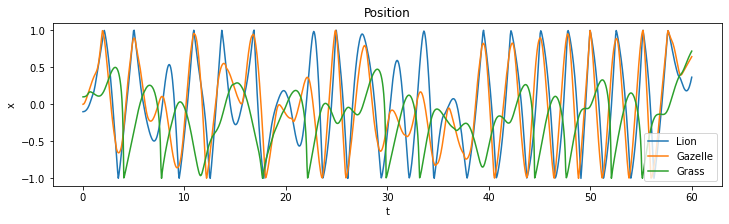

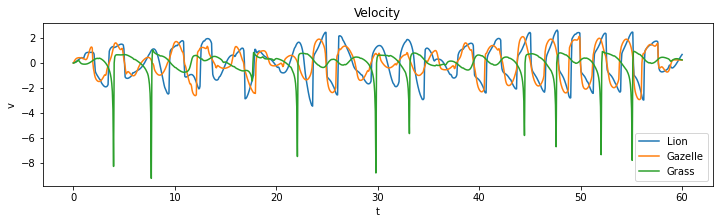

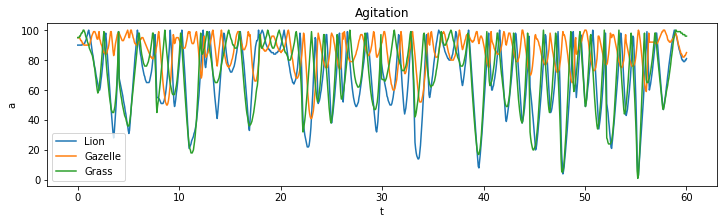

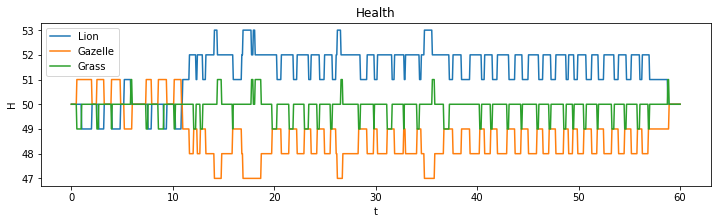

In [11]:
epsilon = 1e-3
lion    = Animal(-0.1)   # 1
gazelle = Animal()  # 2
grass   = Animal(0.1)   # 3

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage
interaction = [1,1,1]

real_engine = Engine([lion, gazelle, grass], evolution_parametters, interaction)
[t, carnivore, herbivore, plant] = real_engine.run()

showall(t, carnivore, herbivore, plant)

May be interesting :

In [12]:
evolution_parametters = [[2,1,1], # faim
                        [1,2,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0,0,3]] # freinage

evolution_parametters = [[4,2,1], # faim
                        [2,4,1], # peur
                        [0.1,0.1,0.1], # distance peur
                        [1e-1,1e-1,1e-1],# repulsion bord
                        [0.5,0.5,3]] # freinage

Note : there seems to be an attraction to the bottom. Indeed, in each simulation I tried they always manage to get in straight line to the lower border.